# Overview
### **<center>Кейс 4. Классификация с использованием набора данных об академических успехах.</center>**

*Состав:*
- Музафаров Карим
- Цуркан Владислав
- Зенченко Илья
- Лямцев Иван
- Скиф Даниель
- Богдан

## Краткий обзор набора данных:
Цель: Набор данных был создан в рамках проекта, направленного на сокращение отсева и неуспеваемости в высших учебных заведениях.  

<br>
Признаки в наборе:  

- Perosonal Information: Marital status, gender, age at enrollment, nationality, international status, displaces status
- Family Background: Mother's and father's qualification and occupation
- Application and Admission: Application mode, application order, course, admission grade
- Academic Background: Previous qualification, previous qualification grade
- Academic Performance: Curricular units in the 1st and 2nd semesters(credited, enrolled, evaluations, approved, grades, without evaluations)
- Attendance and Financial Status: Daytime/evening attendance, educational special needs, debtor status, tuition fees up to data, scholarship holder
- Economic Indicators: Unemployment rate, inflation rate, GDP  
<br>
<br>  

- Личная информация: Семейное положение, пол, возраст при поступлении, гражданство, статус иностранного студента, статус перемещенного лица
- Семейное происхождение: Образование и профессия матери и отца
- Подача заявления и зачисление: Способ подачи заявления, очередность заявления, курс, вступительный балл
- Академическая история: Предыдущее образование, оценка предыдущего образования
- Академическая успеваемость: Учебные единицы в 1-м и 2-м семестрах (зачтенные, зачисленные, оценки, утвержденные, баллы, без оценок)
- Посещаемость и финансовое положение: Посещение дневных/вечерних занятий, особые образовательные потребности, статус должника, своевременная оплата обучения, стипендиат
- Экономические показатели: Уровень безработицы, уровень инфляции, ВВП   
<br>  

*Над набором данных была проведена предварительная обработка данных для устранения аномалий, необъяснимых выбросов и пропущенных значений. Набор не содержит дубликатов.*

# Import libraries

In [110]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import optuna

from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, cross_val_predict
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer

from category_encoders import TargetEncoder, OrdinalEncoder

import phik
from phik.report import plot_correlation_matrix

import warnings
warnings.filterwarnings('ignore')

# Import data

In [94]:
train = pd.read_csv("../data/train.csv", index_col="id")
test = pd.read_csv("../data/test.csv", index_col="id")

# EDA

## Общая информация по датасету

In [95]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76518 entries, 0 to 76517
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  76518 non-null  int64  
 1   Application mode                                76518 non-null  int64  
 2   Application order                               76518 non-null  int64  
 3   Course                                          76518 non-null  int64  
 4   Daytime/evening attendance                      76518 non-null  int64  
 5   Previous qualification                          76518 non-null  int64  
 6   Previous qualification (grade)                  76518 non-null  float64
 7   Nacionality                                     76518 non-null  int64  
 8   Mother's qualification                          76518 non-null  int64  
 9   Father's qualification                      

Набор данных содержит 3 класса: Graduate, Dropout, Enrolled. В рамках нашей задачи поставлена цель сократить количество не закончивших(Dropout) обучение в высшем учебном заведении. В таком случае есть смысл избавиться от необходимости классификации обучающихся в данный момент(Enrolled). Обнаруживать студентов в группе риска планируется по данным на момент поступления (из набора данных также будут удалены данные по успеваемости за 1-2 семестр и другие признаки влияющие на утечку данных).

In [96]:
target = "Target"
enrolled_class_name = "Enrolled"

train = train[train[target] != enrolled_class_name]


# Список признаков для удаления
delete_features = [
    'Curricular units 1st sem (credited)',
    'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)',
    'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (grade)',
    'Curricular units 1st sem (without evaluations)',
    'Curricular units 2nd sem (credited)',
    'Curricular units 2nd sem (credited)',
    'Curricular units 2nd sem (enrolled)', 
    'Curricular units 2nd sem (evaluations)',
    'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (grade)',
    'Curricular units 2nd sem (without evaluations)',
    'Debtor'
]

train = train.drop(columns=delete_features, errors='ignore')
test = test.drop(columns=delete_features, errors='ignore')

Информация после удаления

In [97]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61578 entries, 0 to 76517
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Marital status                  61578 non-null  int64  
 1   Application mode                61578 non-null  int64  
 2   Application order               61578 non-null  int64  
 3   Course                          61578 non-null  int64  
 4   Daytime/evening attendance      61578 non-null  int64  
 5   Previous qualification          61578 non-null  int64  
 6   Previous qualification (grade)  61578 non-null  float64
 7   Nacionality                     61578 non-null  int64  
 8   Mother's qualification          61578 non-null  int64  
 9   Father's qualification          61578 non-null  int64  
 10  Mother's occupation             61578 non-null  int64  
 11  Father's occupation             61578 non-null  int64  
 12  Admission grade                 61578

## Выделим признаки по типу данных

In [98]:
features = test.columns.to_list()

categorical_features = train.select_dtypes(include=int).columns.to_list()
continuous_features = train.select_dtypes(include=float).columns.to_list()

binary_features = [col for col in categorical_features 
                   if train[col].nunique() == 2 and col != target]

discrete_features = [col for col in categorical_features 
                     if col.startswith("Curricular")] + ["Age at enrollment"]

numeric_features = continuous_features + discrete_features

multi_category_features = [col for col in categorical_features 
                          if col not in binary_features and col not in discrete_features and col != target]

categorical_features = binary_features + multi_category_features


In [99]:
print(f"Числовые признаки: {numeric_features}")
print(f"Бинарные признаки: {binary_features}")
print(f"Категориальные признаки: {multi_category_features}")

Числовые признаки: ['Previous qualification (grade)', 'Admission grade', 'Unemployment rate', 'Inflation rate', 'GDP', 'Age at enrollment']
Бинарные признаки: ['Daytime/evening attendance', 'Displaced', 'Educational special needs', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International']
Категориальные признаки: ['Marital status', 'Application mode', 'Application order', 'Course', 'Previous qualification', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation"]


## Проверка на пропуски и дубликаты

In [100]:
train.isna().sum()

Marital status                    0
Application mode                  0
Application order                 0
Course                            0
Daytime/evening attendance        0
Previous qualification            0
Previous qualification (grade)    0
Nacionality                       0
Mother's qualification            0
Father's qualification            0
Mother's occupation               0
Father's occupation               0
Admission grade                   0
Displaced                         0
Educational special needs         0
Tuition fees up to date           0
Gender                            0
Scholarship holder                0
Age at enrollment                 0
International                     0
Unemployment rate                 0
Inflation rate                    0
GDP                               0
Target                            0
dtype: int64

In [101]:
train.duplicated().sum()

np.int64(78)

После удаления части признаков у нас появились дубликаты. Так как в изначальном наборе данных дубликатов не было, мы можем быть уверены, что это разные объекты и оставить их без изменений.

In [102]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Marital status,61578.0,1.118516,0.451832,1.00,1.0,1.00,1.00,6.00
Application mode,61578.0,16.146140,16.673750,1.00,1.0,17.00,39.00,53.00
Application order,61578.0,1.675680,1.258984,0.00,1.0,1.00,2.00,6.00
Course,61578.0,8954.825197,1925.809939,33.00,9119.0,9254.00,9670.00,9991.00
Daytime/evening attendance,61578.0,0.911202,0.284454,0.00,1.0,1.00,1.00,1.00
Previous qualification,61578.0,3.639076,8.400165,1.00,1.0,1.00,1.00,43.00
Previous qualification (grade),61578.0,132.890601,11.117593,95.00,127.0,133.10,140.00,190.00
Nacionality,61578.0,1.225860,3.334185,1.00,1.0,1.00,1.00,109.00
Mother's qualification,61578.0,20.118321,15.423290,1.00,1.0,19.00,37.00,44.00
Father's qualification,61578.0,23.492579,14.961971,1.00,3.0,19.00,37.00,44.00


- Пропусков нет
- Наблюдается сильный дисбаланс в категориальных признаках

## Распределение признаков

### Распределение категориальных признаков

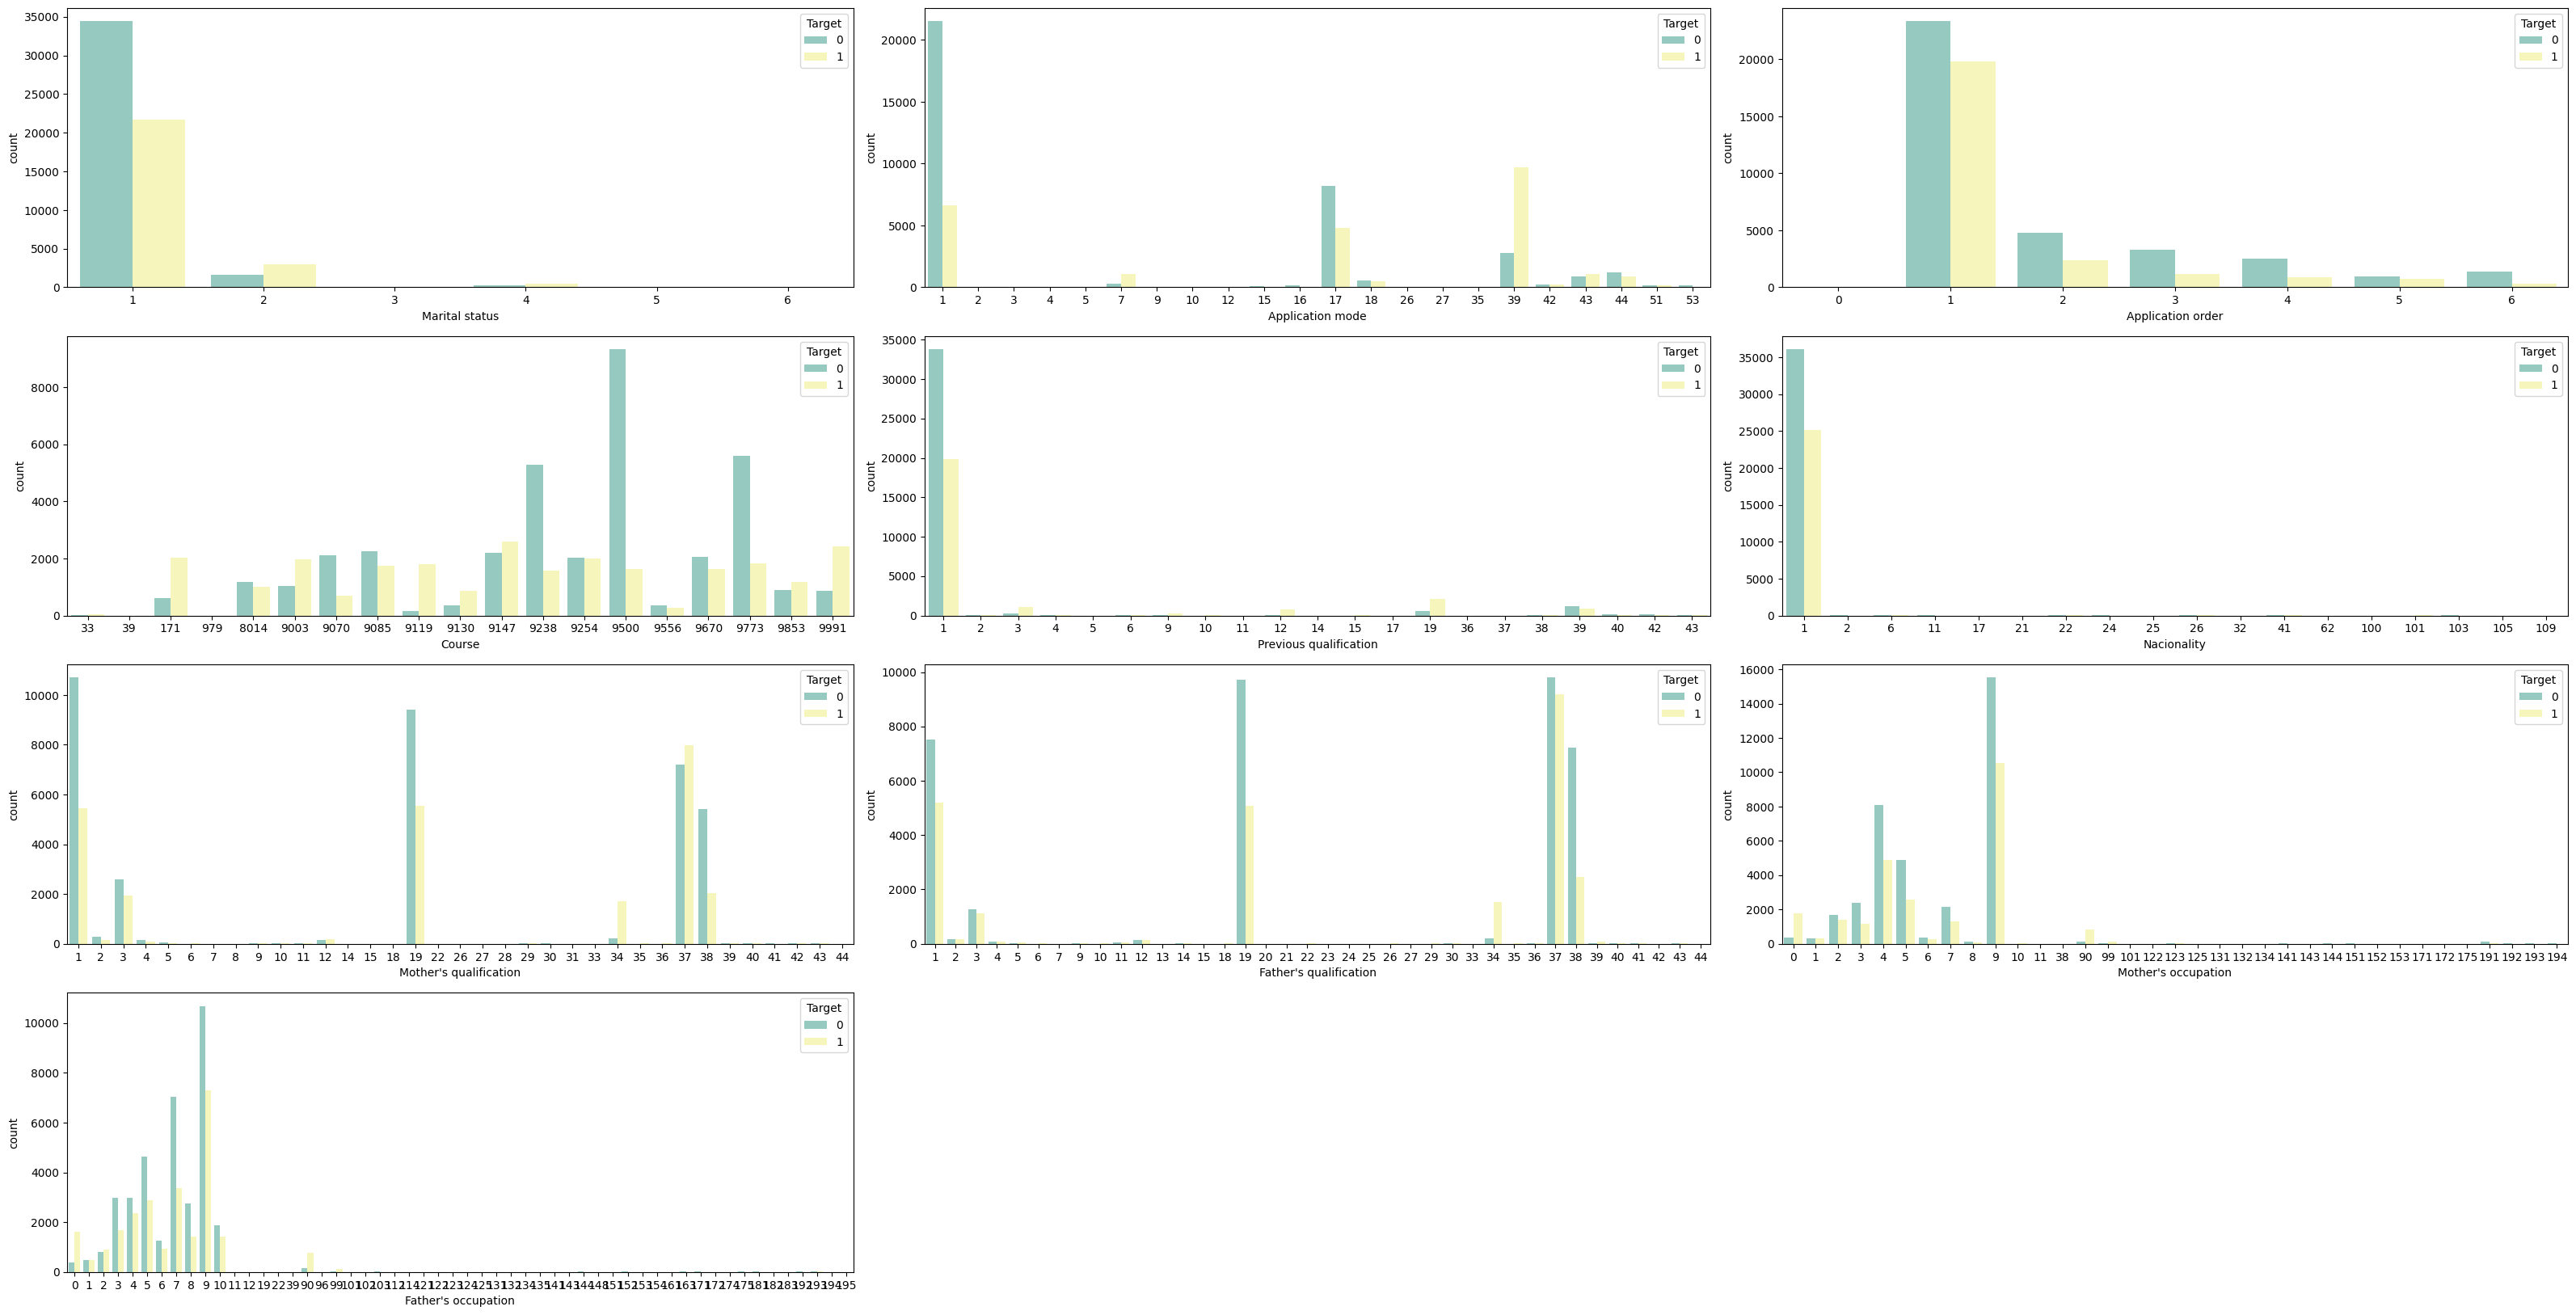

In [74]:
plt.figure(figsize=(32, 20))
for i, col in enumerate(categorical_features):
    plt.subplot(5, 3, i+1)
    sns.countplot(data=train, x=col, hue=target, palette="Set3")
plt.tight_layout()
plt.show()

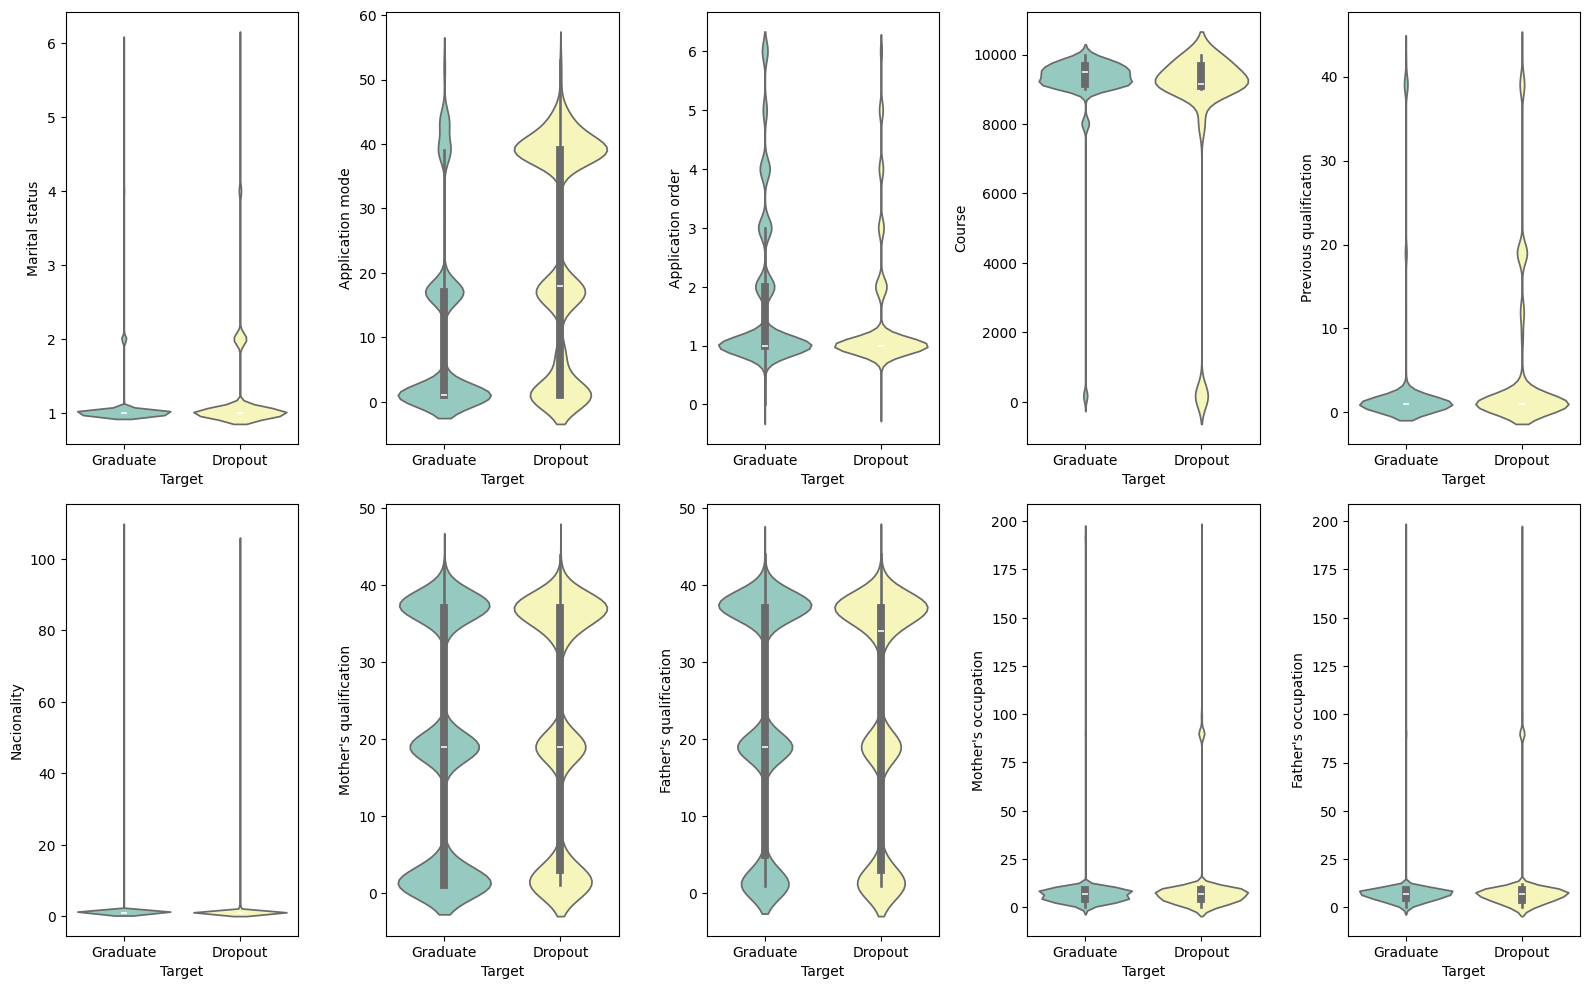

In [39]:
plt.figure(figsize=(16, 10))
for i, col in enumerate(multi_category_features):
    plt.subplot(2, 5, i+1)
    sns.violinplot(data=train, x=target, y=col, hue=target, palette="Set3")
plt.tight_layout()
plt.show()

### Распределение числовых признаков

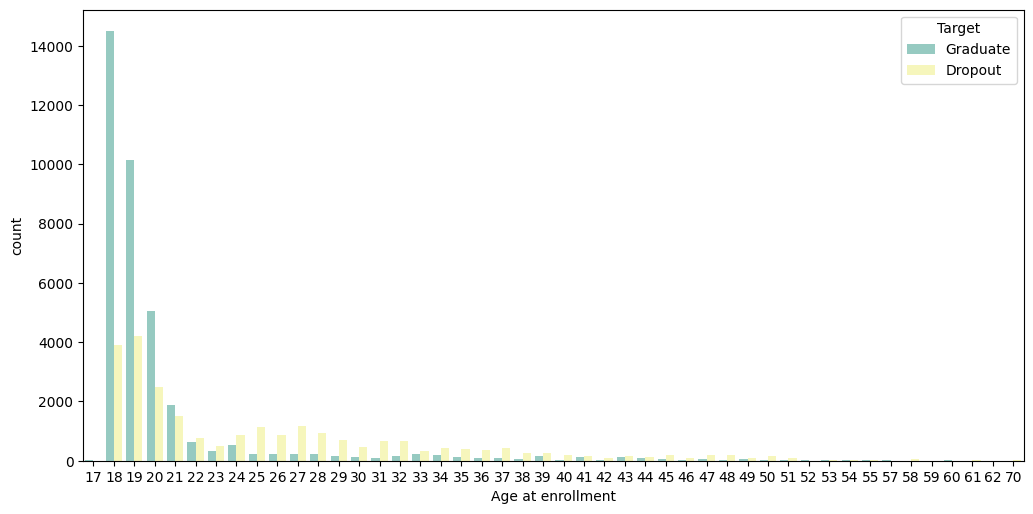

In [48]:
plt.figure(figsize=(20, 15))
for i, col in enumerate(discrete_features):
    plt.subplot(3, 2, i+1)
    sns.countplot(data=train, x=col, hue=target, palette="Set3")
plt.tight_layout()
plt.show()

Правосторонняя ассиметрия по возрсту

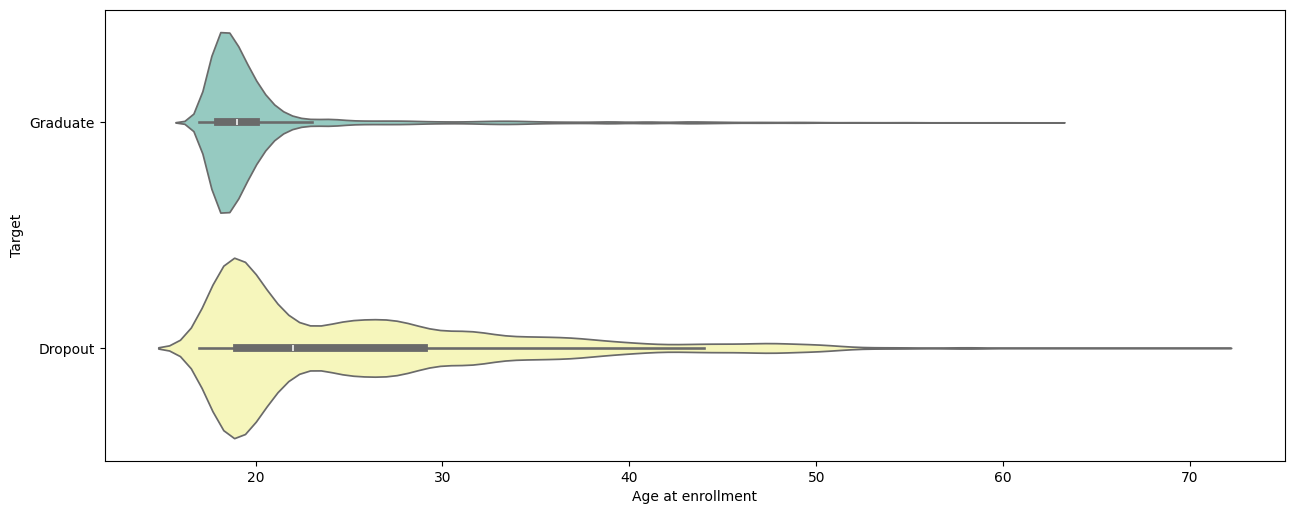

In [49]:
plt.figure(figsize=(25, 15))
for i, col in enumerate(discrete_features):
    plt.subplot(3, 2, i+1)
    sns.violinplot(data=train, x=col, y=target, hue=target, palette="Set3")
plt.tight_layout()
plt.show()

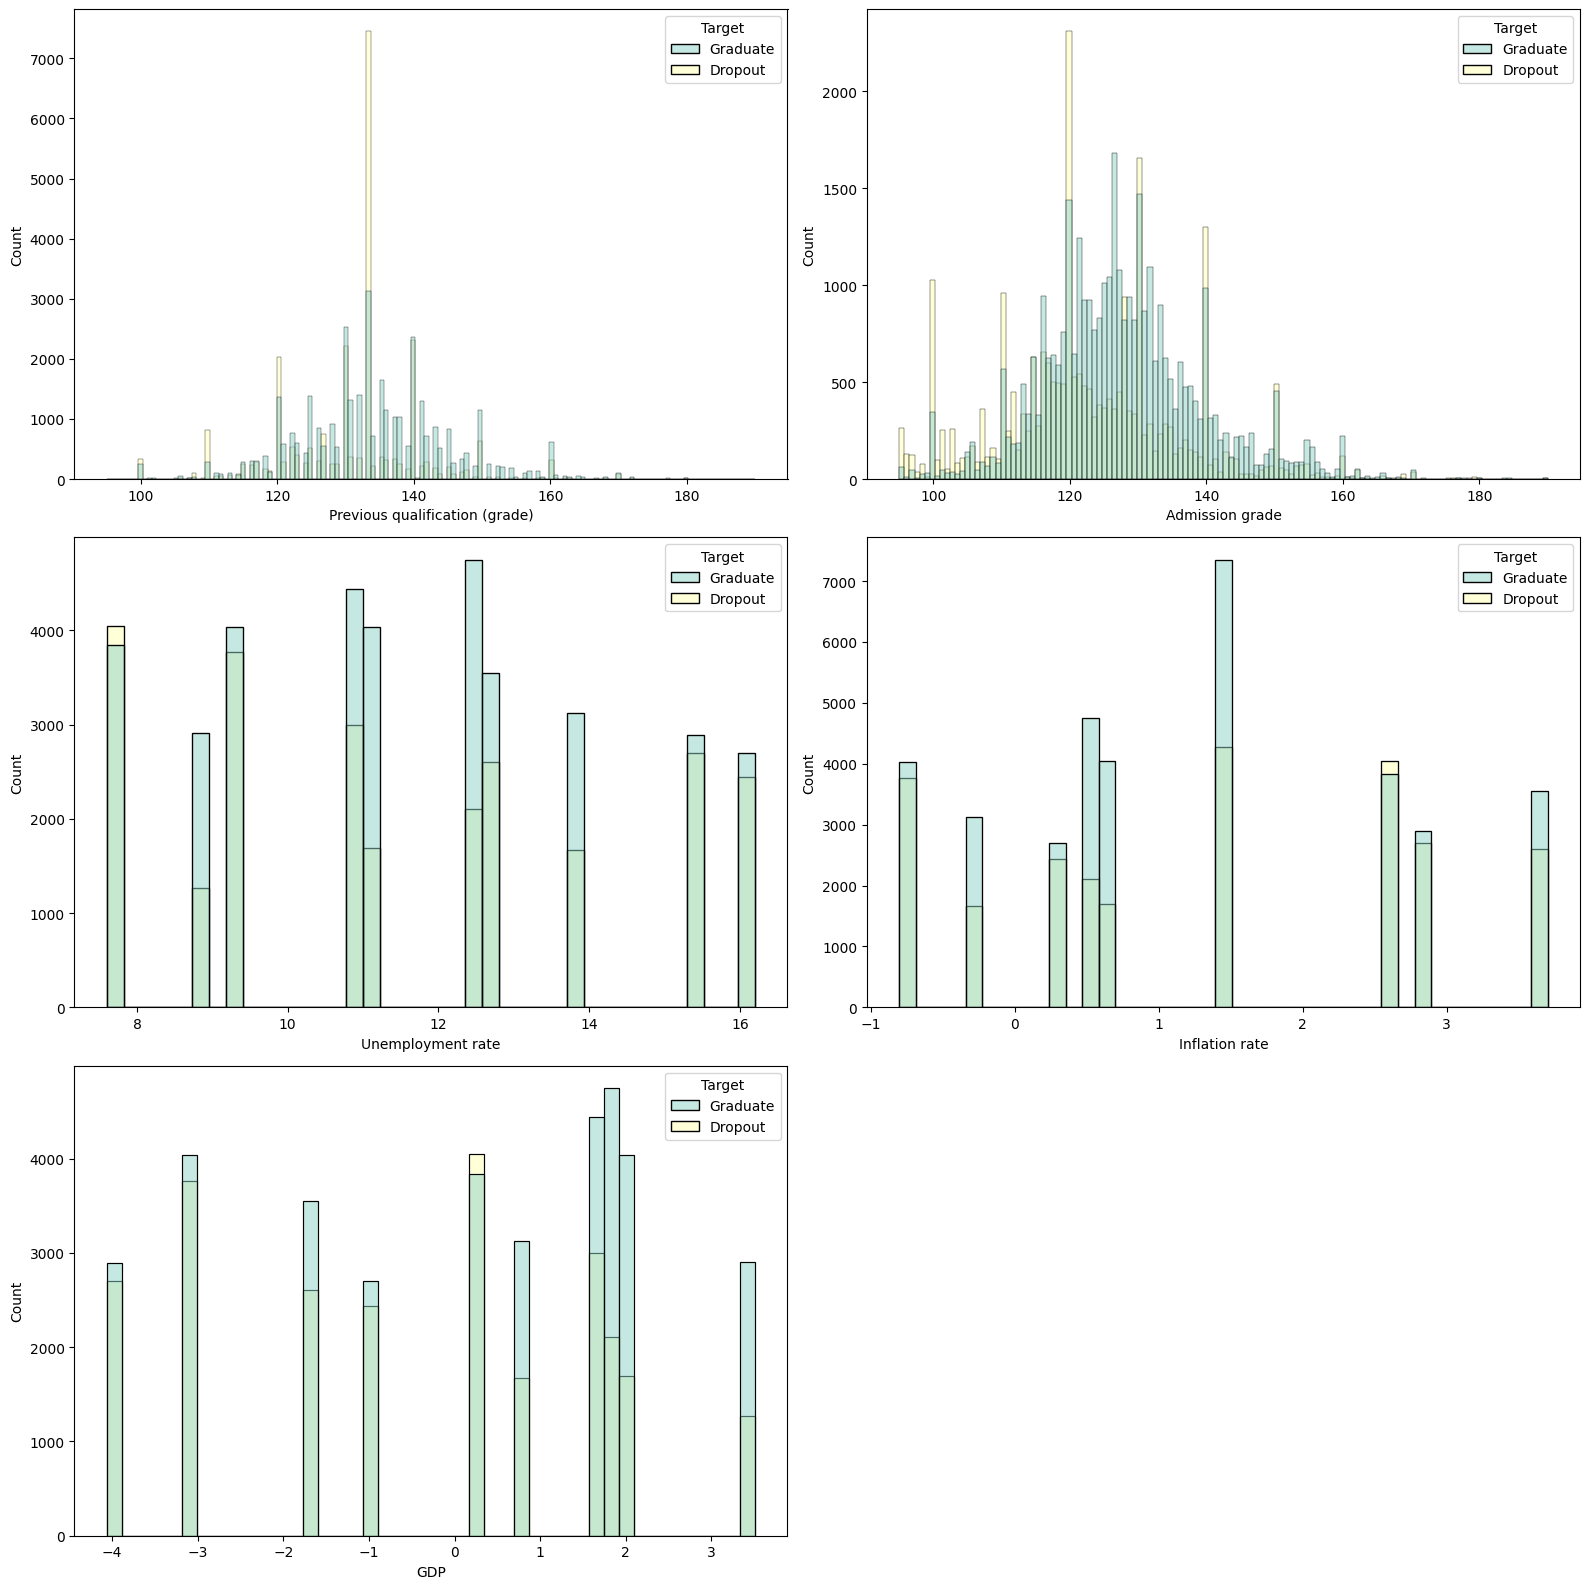

In [51]:
plt.figure(figsize=(16, 16))
for i, col in enumerate(continuous_features):
    plt.subplot(3, 2, i+1)
    sns.histplot(data=train, x=col, hue=target, palette="Set3")
plt.tight_layout()
plt.show()

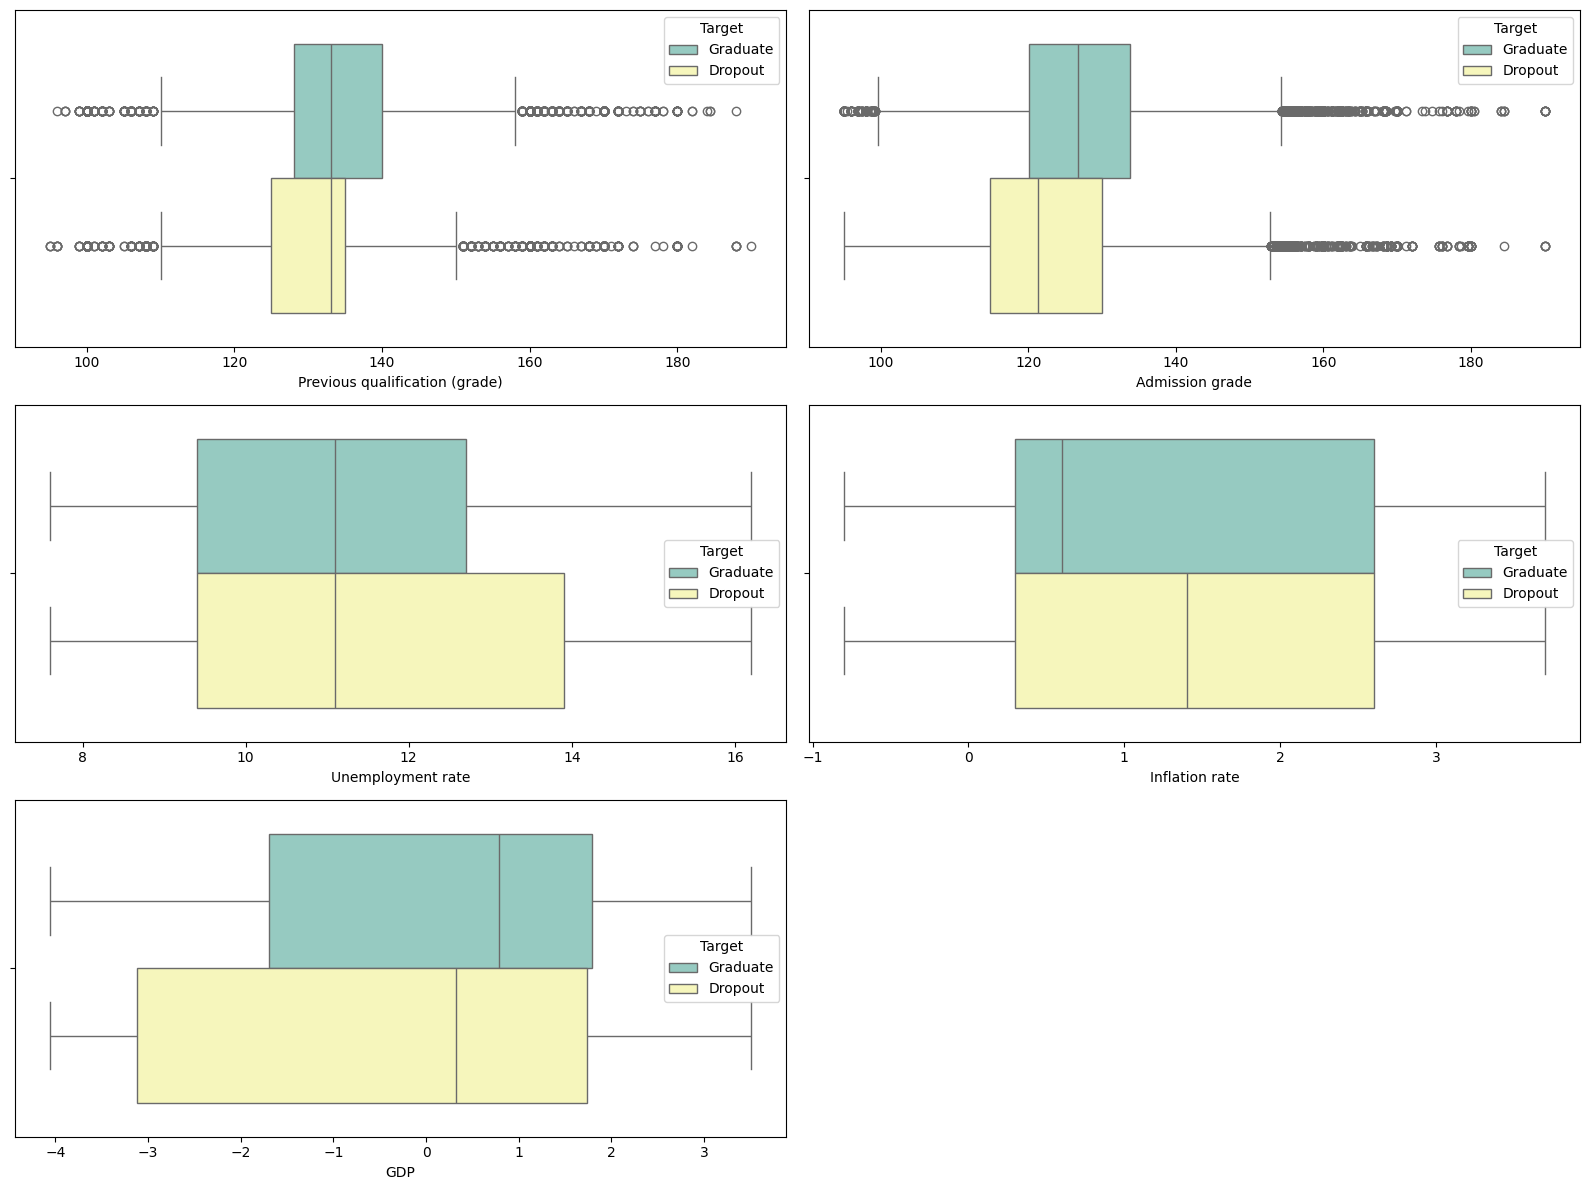

In [52]:
plt.figure(figsize=(16, 12))
for i, col in enumerate(continuous_features):
    plt.subplot(3, 2, i+1)
    sns.boxplot(data=train, x=col, hue=target, palette="Set3")
plt.tight_layout()
plt.show()

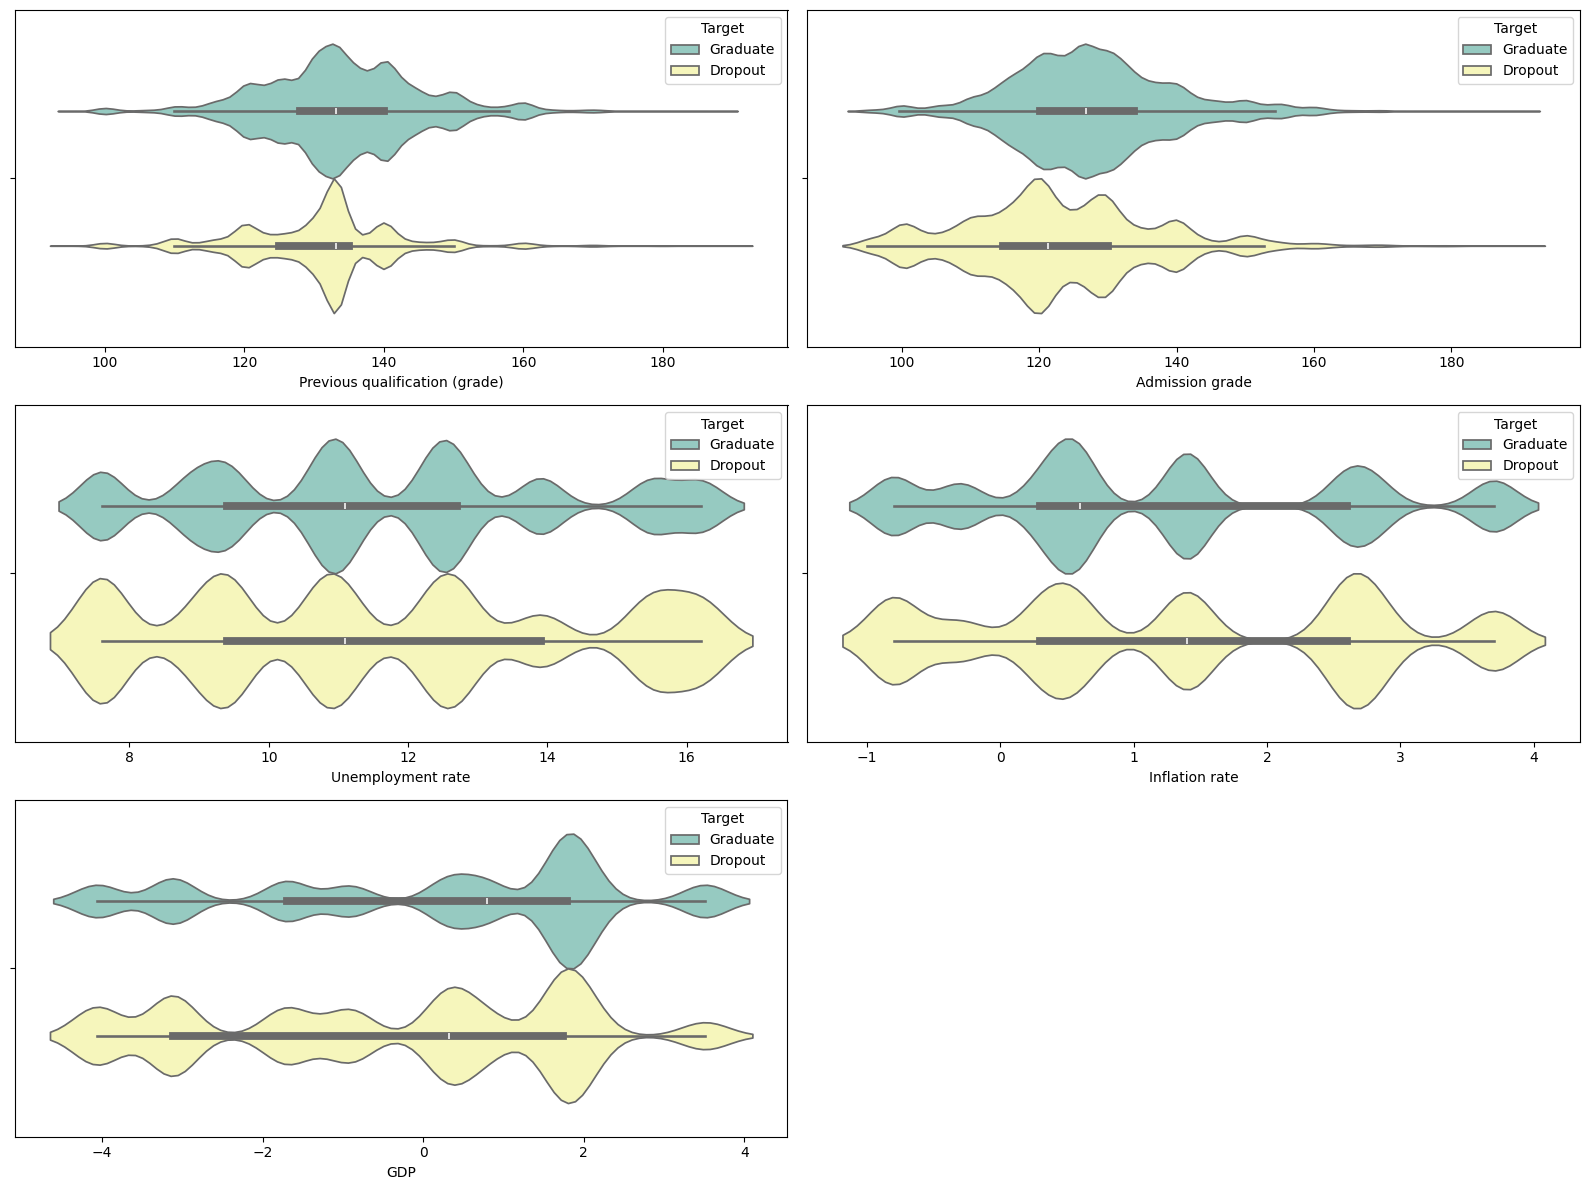

In [53]:
plt.figure(figsize=(16, 12))
for i, col in enumerate(continuous_features):
    plt.subplot(3, 2, i+1)
    sns.violinplot(data=train, x=col, hue=target, palette="Set3")
plt.tight_layout()
plt.show()

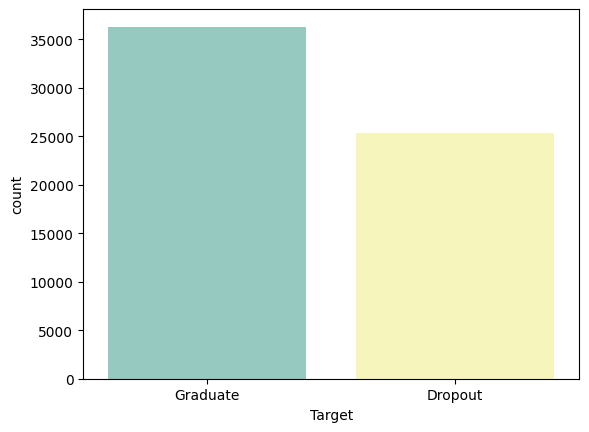

In [54]:
sns.countplot(data=train, x=target, hue=target, palette="Set3")
plt.show()

## Корреляция

interval columns not set, guessing: ['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Unemployment rate', 'Inflation rate', 'GDP', 'Target']


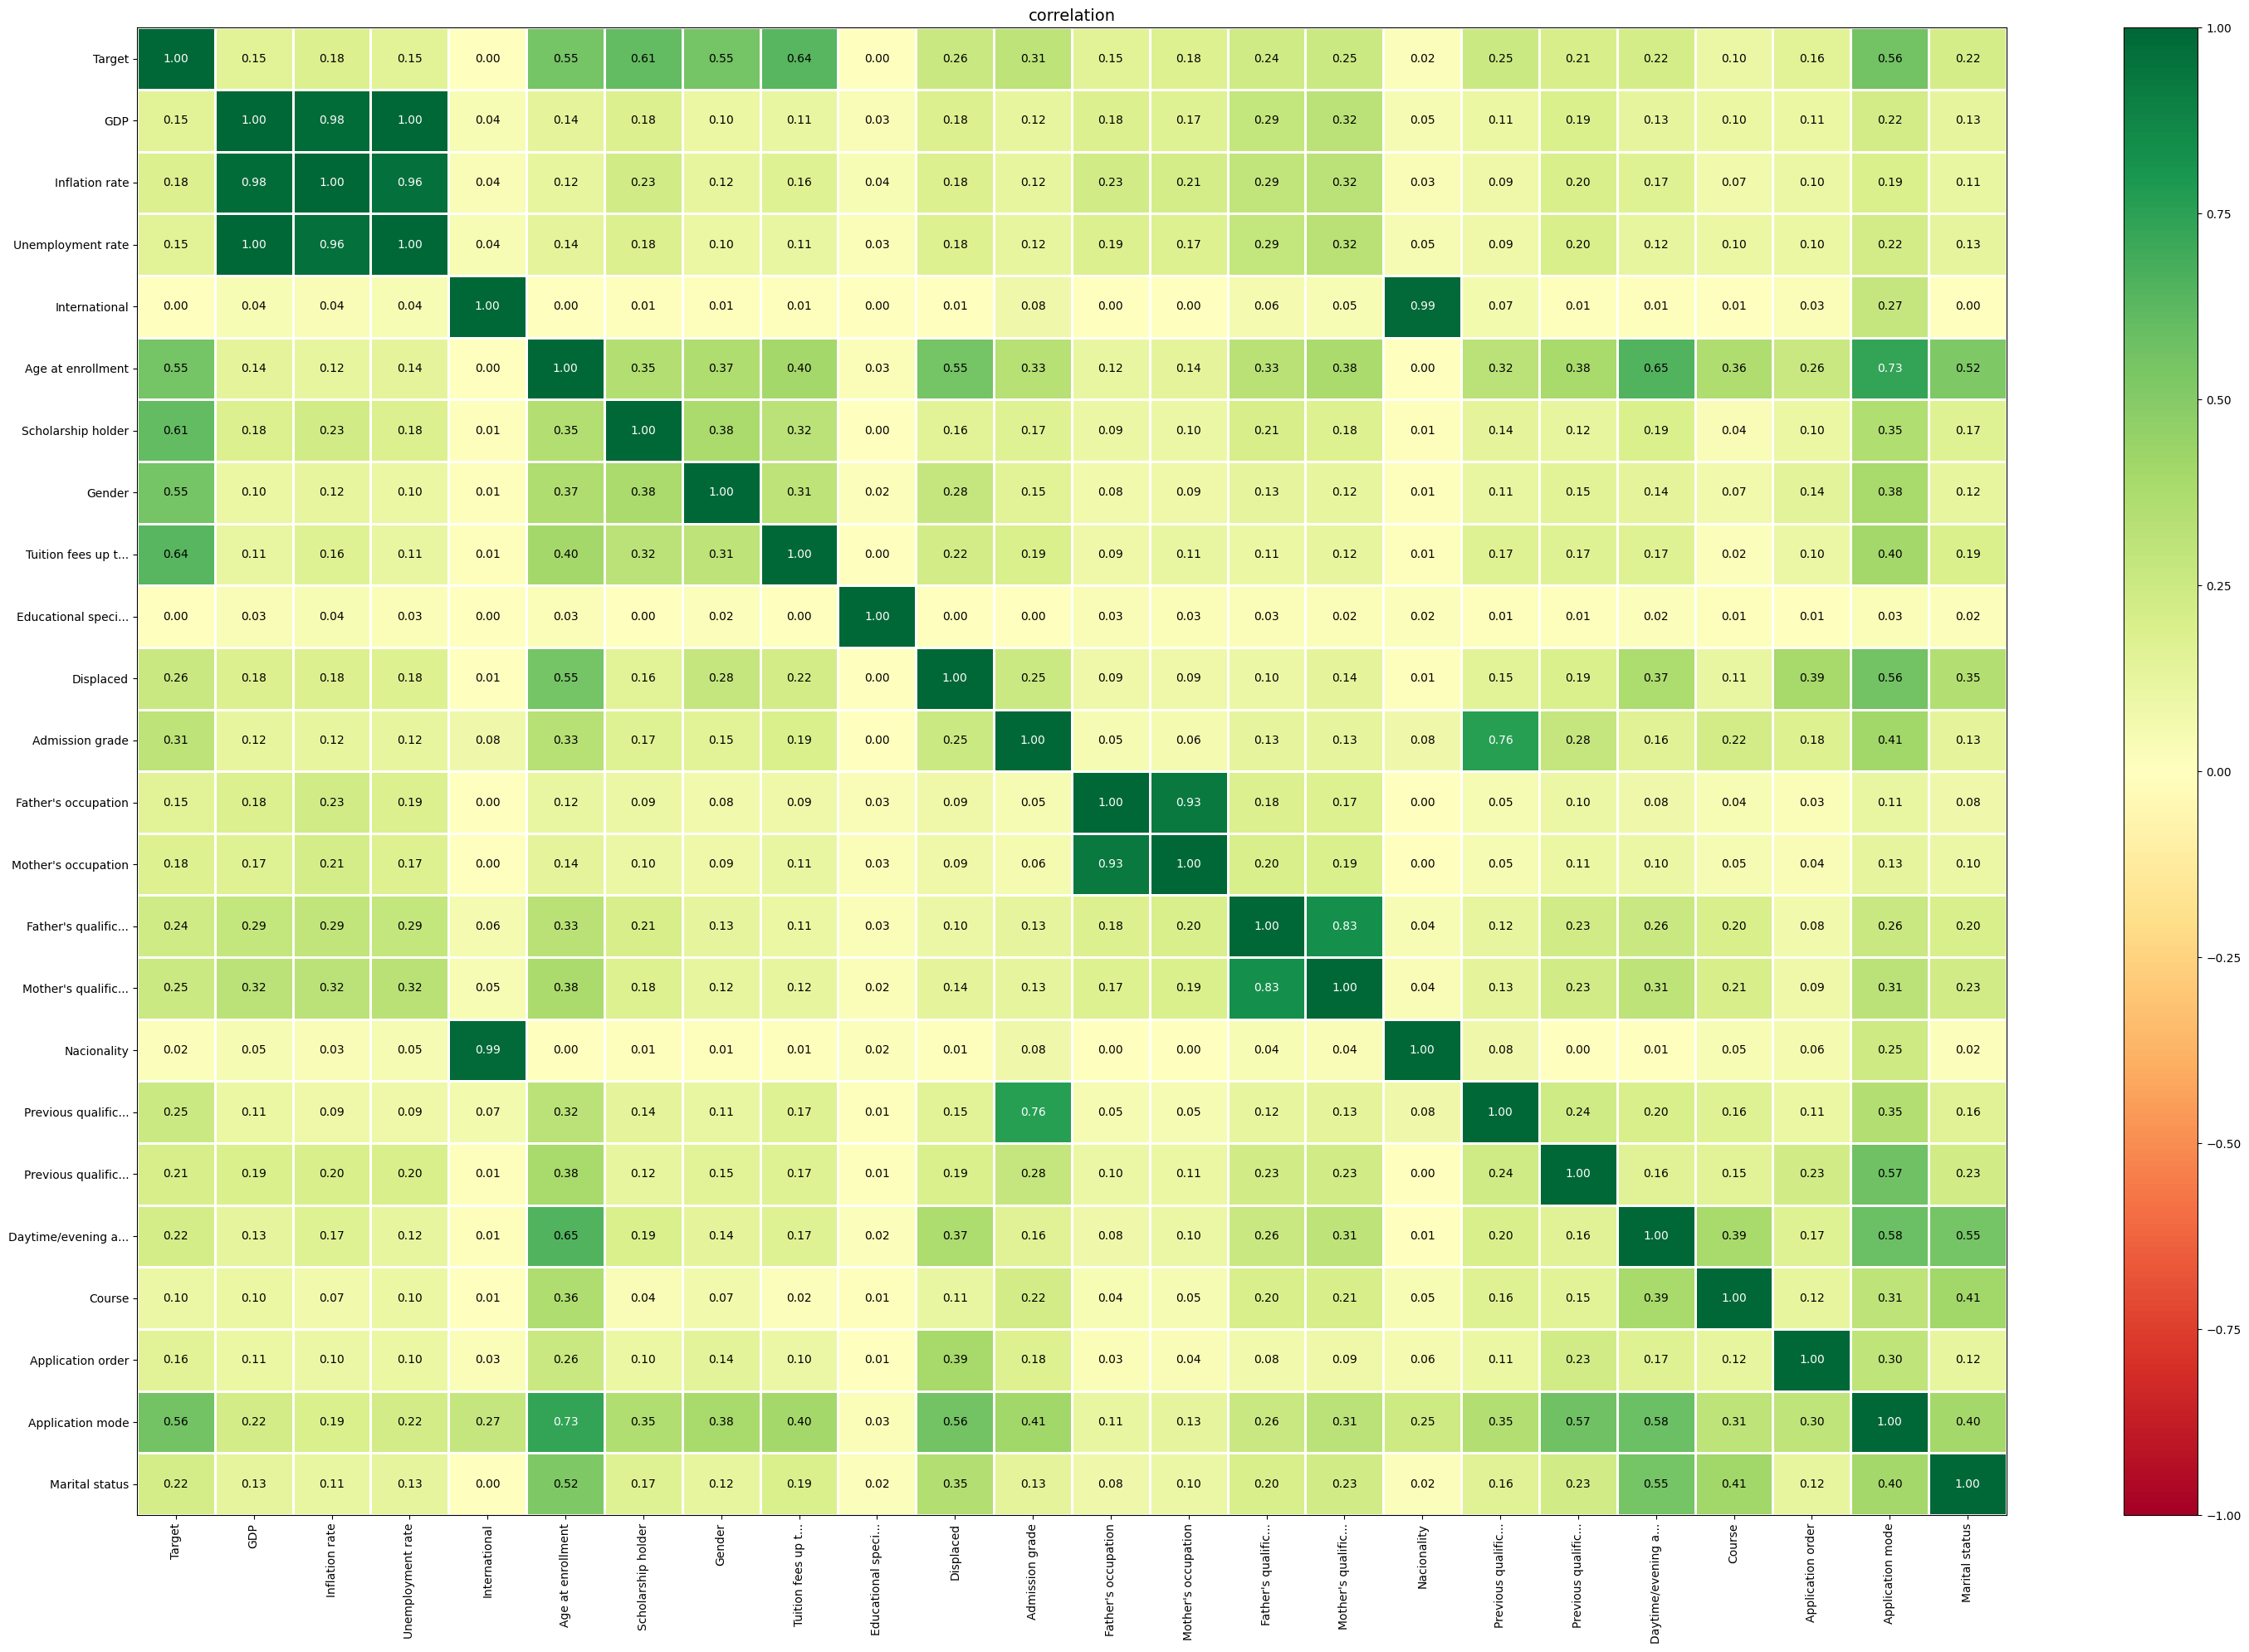

In [103]:
train["Target"] = (train["Target"] == 'Dropout').astype(int)


corr_matrix = train.phik_matrix()
plot_correlation_matrix(corr_matrix.values, x_labels=corr_matrix.columns, y_labels=corr_matrix.index, figsize=(30,20))

### Выводы:
- Наблюдается дисбаланс целевых классов
- Ряд признаков имеет сильную правостороннюю асимметрию и выбросы.
- Категориальные признаки зачастую несбалансированны.


Feature engineering
- Между nacionality(национальность) и international(является ли иностранным студентом) сильная корреляция. Можно дропнуть nacionality и оставить только признак international.
- Между Unemployment rate(Уровень безработицы), Inflation rate(Уровень инфляции), GDP(Валовой внутренний продукт) сильная корреляция. Можно оставить один признак из них(unemployment rate больше всего коррелирует с target)

# Baseline model

In [127]:
X = train.drop(target, axis=1).copy()
y = train[target].copy()

- Recall выбран как основная метрика, потому что в задаче прогнозирования отчисления студентов критически важно минимизировать число пропущенных случаев (ложно отрицательных), когда студент отчисляется, но модель этого не предсказала. Пропуск таких студентов означает упущенную возможность оказать им поддержку.
- Для числовых признаков выбран RobustScaler, так как анализ распределений показал наличие выбросов в данных.
- Для категориальных признаков применён TargetEncoder, так как он эффективно преобразует категории в числовые признаки, отражающие статистическую связь с целевой переменной. При использовании OHE у нас будет большое количество признаков.

In [106]:
numerical_features = [
    'Previous qualification (grade)', 'Admission grade', 'Unemployment rate', 
    'Inflation rate', 'GDP'
]

discrete_features = [
    'Age at enrollment'
]

binary_features = [
    'Daytime/evening attendance', 'Displaced', 'Educational special needs',
    'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International'
]

categorical_features = [
    'Marital status', 'Application mode', 'Application order', 
    'Course', 'Previous qualification', 'Nacionality', 
    "Mother's qualification", "Father's qualification",
    "Mother's occupation", "Father's occupation"
]

def create_pipeline(C=1.0, penalty='l2', solver='lbfgs', 
                   class_weight=None, smoothing=10.0):
    
    preprocessor = ColumnTransformer([
        ('scaler', RobustScaler(), numerical_features + discrete_features),
        ('binary', 'passthrough', binary_features),
        ('cat', TargetEncoder(cols=categorical_features, smoothing=smoothing), 
         categorical_features)
    ], remainder='drop')
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(
            C=C,
            penalty=penalty,
            solver=solver,
            class_weight=class_weight,
            max_iter=1000,
            random_state=42,
            n_jobs=-1
        ))
    ])
    
    return pipeline

def objective(trial):
    params = {
        'C': trial.suggest_float('C', 1e-3, 10, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'smoothing': trial.suggest_float('smoothing', 1, 100, log=True),
    }
    
    if params['penalty'] == 'l1':
        params['solver'] = 'liblinear'
    else:
        params['solver'] = 'lbfgs'
    
    pipeline = create_pipeline(**params)
    
    cv_score = cross_val_score(
        pipeline, X, y,
        cv=StratifiedKFold(n_splits=7, shuffle=True, random_state=42),
        scoring='recall',
        n_jobs=-1
    ).mean()
    
    return cv_score

In [107]:
print("Оптимизация гиперпараметров...")
study = optuna.create_study(direction='maximize', study_name='logreg_opt')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print(f"\nЛучший recall: {study.best_value:.4f}")

[I 2025-12-04 16:18:51,901] A new study created in memory with name: logreg_opt


Оптимизация гиперпараметров...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-04 16:18:54,218] Trial 0 finished with value: 0.737073119689252 and parameters: {'C': 1.3921547825040936, 'penalty': 'l2', 'class_weight': None, 'smoothing': 7.015822331342747}. Best is trial 0 with value: 0.737073119689252.
[I 2025-12-04 16:18:56,125] Trial 1 finished with value: 0.7979131104316536 and parameters: {'C': 0.01579541454636393, 'penalty': 'l2', 'class_weight': 'balanced', 'smoothing': 29.031332979276833}. Best is trial 1 with value: 0.7979131104316536.
[I 2025-12-04 16:18:57,342] Trial 2 finished with value: 0.7688964974536462 and parameters: {'C': 0.0014273083694942238, 'penalty': 'l1', 'class_weight': 'balanced', 'smoothing': 96.0485732607001}. Best is trial 1 with value: 0.7979131104316536.
[I 2025-12-04 16:19:47,201] Trial 3 finished with value: 0.7371917061387737 and parameters: {'C': 6.871487136298662, 'penalty': 'l1', 'class_weight': None, 'smoothing': 2.5421242010904623}. Best is trial 1 with value: 0.7979131104316536.
[I 2025-12-04 16:19:48,422] Trial 

In [79]:
best_params = study.best_params.copy()
best_params['solver'] = 'liblinear' if best_params['penalty'] == 'l1' else 'lbfgs'
final_pipeline = create_pipeline(**best_params)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(final_pipeline, X, y, cv=cv, n_jobs=-1)

report = classification_report(y, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.84      0.85     36282
           1       0.78      0.80      0.79     25296

    accuracy                           0.82     61578
   macro avg       0.82      0.82      0.82     61578
weighted avg       0.82      0.82      0.82     61578



Text(50.722222222222214, 0.5, 'Истинные метки')

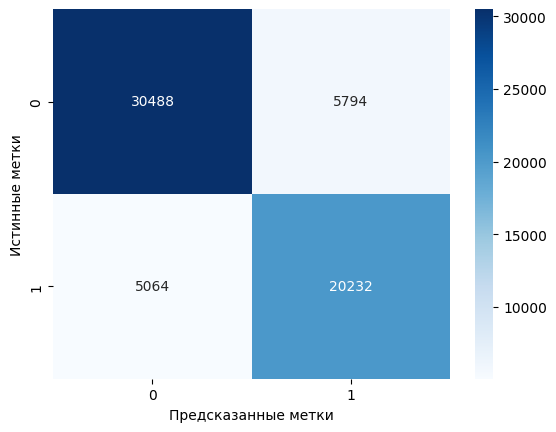

In [85]:
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')

In [87]:
print("Лучшие параметры:", study.best_params)

Лучшие параметры: {'C': 0.4299689649286296, 'penalty': 'l2', 'class_weight': 'balanced', 'smoothing': 36.06778500352638}


In [88]:
best_params = study.best_params.copy()
best_params['solver'] = 'liblinear' if best_params['penalty'] == 'l1' else 'lbfgs'
final_model = create_pipeline(**best_params)
final_model.fit(X, y)

preprocessor = final_model.named_steps['preprocessor']


feature_names = []

feature_names.extend(numerical_features + discrete_features)

feature_names.extend(binary_features)

feature_names.extend(categorical_features)


coefs = final_model.named_steps['classifier'].coef_[0]


fi = (
    pd.DataFrame({"feature": feature_names, "coef": coefs})
      .assign(abs_coef=lambda d: d["coef"].abs())
      .sort_values("abs_coef", ascending=False)
)

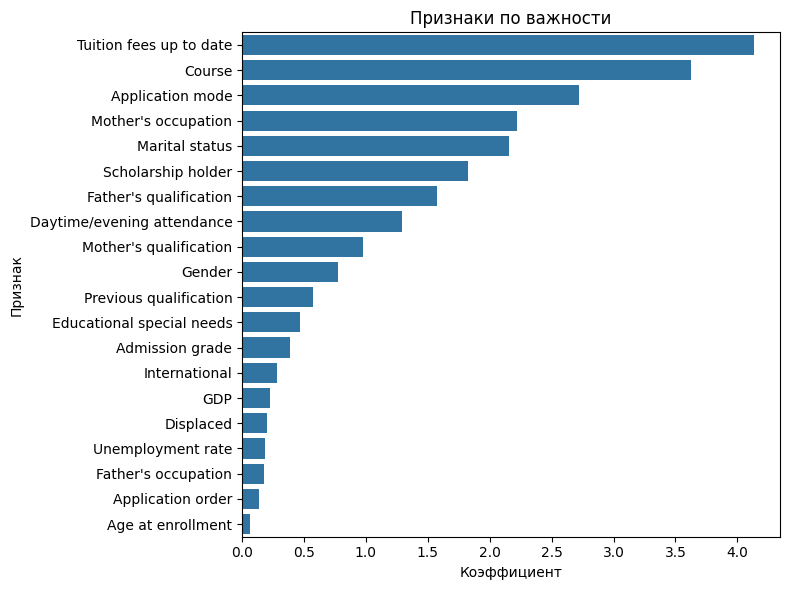

In [89]:
TOP_N = 20

plt.figure(figsize=(8, 6))
sns.barplot(data=fi.head(TOP_N), x="abs_coef", y="feature")
plt.xlabel("Коэффициент")
plt.ylabel("Признак")
plt.title(f"Признаки по важности")
plt.tight_layout()
plt.show()

# DT

In [136]:
num_features = ['Previous qualification (grade)', 'Admission grade', 
                'Unemployment rate', 'Inflation rate', 'GDP', 'Age at enrollment']

bin_features = ['Daytime/evening attendance', 'Displaced', 'Educational special needs',
                'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International']

cat_features = ['Marital status', 'Application mode', 'Course', 'Previous qualification', 
                'Nacionality', "Mother's qualification", "Father's qualification",
                "Mother's occupation", "Father's occupation", 'Application order']


def create_dt_pipeline(params):
    preprocessor = ColumnTransformer([
        ('num', 'passthrough', num_features),
        ('bin', 'passthrough', bin_features),
        ('cat', TargetEncoder(cols=categorical_features), 
         categorical_features)
    ], remainder='drop')
    

    dt_params = {k: v for k, v in params.items() if k not in ['preprocessor']}
    
    return Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(**dt_params, random_state=42))
    ])

def objective(trial, X, y, cv_folds=5, scoring='recall'):

    params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 10, 100, step=10),
        'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.0, 0.1),
        'ccp_alpha': trial.suggest_float('ccp_alpha', 0.0, 0.1)
    }
    
    pipeline = create_dt_pipeline(params)
    
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    return scores.mean()

In [146]:
def optimize_decision_tree(X, y, n_trials=100, scoring='recall', cv_folds=5, timeout=None):
    study = optuna.create_study(
        direction='maximize',
        study_name='decision_tree_optimization',
        sampler=optuna.samplers.TPESampler(seed=42),
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
    )
    
    study.optimize(
        lambda trial: objective(trial, X, y, cv_folds, scoring),
        n_trials=n_trials,
        timeout=timeout,
        show_progress_bar=True,
        n_jobs=1
    )
    

    print(f"Лучшее значение {scoring}: {study.best_value:.4f}")
    print("\nЛучшие параметры:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
    
    return study

In [147]:
study = optimize_decision_tree(X, y, n_trials=100, scoring="recall")

[I 2025-12-04 17:04:27,756] A new study created in memory with name: decision_tree_optimization


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-04 17:04:30,134] Trial 0 finished with value: 0.0 and parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2', 'class_weight': None, 'max_leaf_nodes': 100, 'min_impurity_decrease': 0.08324426408004218, 'ccp_alpha': 0.021233911067827616}. Best is trial 0 with value: 0.0.
[I 2025-12-04 17:04:32,048] Trial 1 finished with value: 0.8028936728422794 and parameters: {'criterion': 'log_loss', 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 80, 'min_impurity_decrease': 0.019967378215835975, 'ccp_alpha': 0.05142344384136116}. Best is trial 1 with value: 0.8028936728422794.
[I 2025-12-04 17:04:33,703] Trial 2 finished with value: 0.8028936728422794 and parameters: {'criterion': 'log_loss', 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 50, 'min_im